In [37]:
import sys
sys.path.append('../../../src/')

import os
from pathlib import Path

from utils import parse, processing, plotting_utils as plotting, AddExtraColumns

# Plotting libraries
from matplotlib.backends.backend_pdf import PdfPages
import datetime
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'

odor_list_color = [color1, color2, color3]
color_dict = {1: color1, 0: color2, 2: color3}
color_dict_label = {'Ethyl Butyrate': color1, 'Alpha-pinene': color2, 'Amyl Acetate': color3}

pdf_path = r'Z:\scratch\vr-foraging\sessions'
base_path = 'Z:/scratch/vr-foraging/data/'
foraging_figures = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\results'

In [38]:
date = datetime.date.today()
date_string = "06/11/2024"
date = datetime.datetime.strptime(date_string, "%m/%d/%Y").date()

In [39]:
# mouse_list = ["672102", "694569", "690164","690165","690167","699894","699895","699899"]
mouse_list = ["715866", "713578", "707349","715865","715869","713545","715867","715870","716455","716456","716457", "716458"]

In [40]:
summary_df = pd.DataFrame()

for mouse in mouse_list:
    print(mouse)
    session_found = False

    directory = os.path.join(base_path, mouse)
    files = os.listdir(os.path.join(base_path, mouse))
    
    sorted_files = sorted(files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=True)
    
    for file_name in sorted_files:
        print(file_name)
        if session_found == True:
            break
        
        session_path = os.path.join(base_path, mouse, file_name)
        session = file_name[:8]
        session_path = Path(session_path)
        
        if datetime.date.fromtimestamp(os.path.getctime(session_path)) != date:
            continue
        else:
            print('correct date found')
            session_found = True
        
        data = parse.load_session_data(session_path)

        if 'tasklogic_input' in data['config'].streams.keys():
            tasklogic = 'tasklogic_input'
        else:
            tasklogic = 'TaskLogic'
            
        # Parse data
        reward_sites, active_site, config = parse.parse_dataframe(data)
        reward_sites = AddExtraColumns(reward_sites, active_site, run_on_init=True).reward_sites
        encoder_data = parse.ContinuousData(data).encoder_data

        color_dict_label = {data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][0]['label']: color1, 
                    data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][1]['label']: color2, 
                    data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][2]['label']: color3},
        color_dict_label = color_dict_label[0]

        last_engaged_patch = reward_sites['active_patch'][reward_sites['skipped_count'] >= 10].min()
        if pd.isna(last_engaged_patch):
            last_engaged_patch = reward_sites['active_patch'].max()
        reward_sites_cropped = reward_sites.loc[reward_sites['active_patch'] <= last_engaged_patch]
        
        trial_summary = plotting.trial_collection(reward_sites_cropped[['odor_sites', 'odor_label', 'has_choice', 'visit_number', 'reward_delivered', 'depleted']], encoder_data, mouse, session, window=(-1,3))
        
        pdf_filename = mouse + '_' + session + '.pdf'

        # Save each figure to a separate page in the PDF
        with PdfPages(pdf_path+"\\"+pdf_filename) as pdf:
            try:
                plotting.length_distributions(active_site, data, delay=True, save=pdf)
            except:
                plotting.length_distributions(active_site, data, save=pdf)
                        
            plotting.speed_traces_efficient(trial_summary, mouse, session,  save=pdf)
            # plotting.segmented_raster_vertical(reward_sites_cropped, 
            #                                    data['config'].streams[tasklogic].data, 
            #                                    save=pdf, 
            #                                    color_dict_label=color_dict_label)
            # plotting.preward_estimates(reward_sites, 
            #                            color_dict_label = color_dict_label, 
            #                            save=pdf)
            # plotting.speed_traces_available(trial_summary, mouse, session, data['config'], save=pdf)
            # plotting.velocity_traces_odor_summary(trial_summary, max_range = trial_summary.speed.max(), save=pdf)
            # plotting.pstay_past_no_rewards(reward_sites_cropped, data['config'].streams['TaskLogic'].data, save=pdf)
            # plotting.pstay_visit_number(reward_sites_cropped, data['config'].streams['TaskLogic'].data, save=pdf)
        
        # Summary of different relevants aspects -------------------------------------------------
        collected_df = reward_sites['collected'].sum()

        unrewarded_stops = reward_sites.loc[reward_sites.reward_delivered==0]['collected'].count()
        rewarded_stops = reward_sites.loc[reward_sites.reward_delivered==1]['collected'].count()
        water_collected = reward_sites.loc[(reward_sites['reward_delivered']==1)]['collected'].sum()
        total_stops = reward_sites.loc[(reward_sites['has_choice']==True)]['reward_available'].count()
        stopped_df = reward_sites.loc[(reward_sites['has_choice']==True)].groupby(['collected','odor_label'])[['reward_delivered']].sum().reset_index()

        # Rewarded stops / total available rewarded stops
        optimality = rewarded_stops / reward_sites[reward_sites.reward_available != 0]['reward_delivered'].count()

        # Rewarded stops / Stops
        efficiency = rewarded_stops / reward_sites.reward_delivered.sum()

        print('Total sites: ' ,len(reward_sites), ' | ', 'Total rewarded stops: ',rewarded_stops, '(',  np.round((rewarded_stops/total_stops)*100,2),'%) | ', 
            'Total unrewarded stops: ',unrewarded_stops,'(',  np.round((unrewarded_stops/total_stops)*100,2),'%) | ','Water consumed: ', water_collected, 'ul')

        if 'startPosition' in active_site.columns:
            stop_duration = np.round(active_site.startPosition.max()/100,2)
        else:
            stop_duration = np.round(active_site.start_position.max()/100,2)
        print('Total travelled m: ', np.round(active_site.start_position.max()/100,2))

        for odor_label in reward_sites.odor_label.unique():
            values = reward_sites.loc[(reward_sites['odor_label']==odor_label)&(reward_sites['reward_delivered']==1)]['collected'].sum()
            print(f'{odor_label} {values} ul')

        reward_sites['mouse'] = mouse
        reward_sites['session'] = session
        summary_df = pd.concat([summary_df, reward_sites])
        

715866
20240611T100249
correct date found
Total sites:  383  |  Total rewarded stops:  175 ( 75.43 %) |  Total unrewarded stops:  208 ( 89.66 %) |  Water consumed:  875.0 ul
Total travelled m:  620.52
2,3-Butanedione 535.0 ul
Methyl Acetate 340.0 ul
Fenchone 0.0 ul
20240610T091806
713578
20240611T100322
correct date found
Total sites:  448  |  Total rewarded stops:  230 ( 72.56 %) |  Total unrewarded stops:  218 ( 68.77 %) |  Water consumed:  1150.0 ul
Total travelled m:  611.43
2,3-Butanedione 830.0 ul
Methyl Acetate 320.0 ul
Fenchone 0.0 ul
20240610T094052
707349
20240611T100331
correct date found
Total sites:  489  |  Total rewarded stops:  250 ( 58.14 %) |  Total unrewarded stops:  239 ( 55.58 %) |  Water consumed:  1250.0 ul
Total travelled m:  539.86
2,3-Butanedione 725.0 ul
Methyl Acetate 525.0 ul
Fenchone 0.0 ul
20240610T090932
715865
20240611T064603
correct date found
Total sites:  368  |  Total rewarded stops:  212 ( 70.43 %) |  Total unrewarded stops:  156 ( 51.83 %) |  Wate

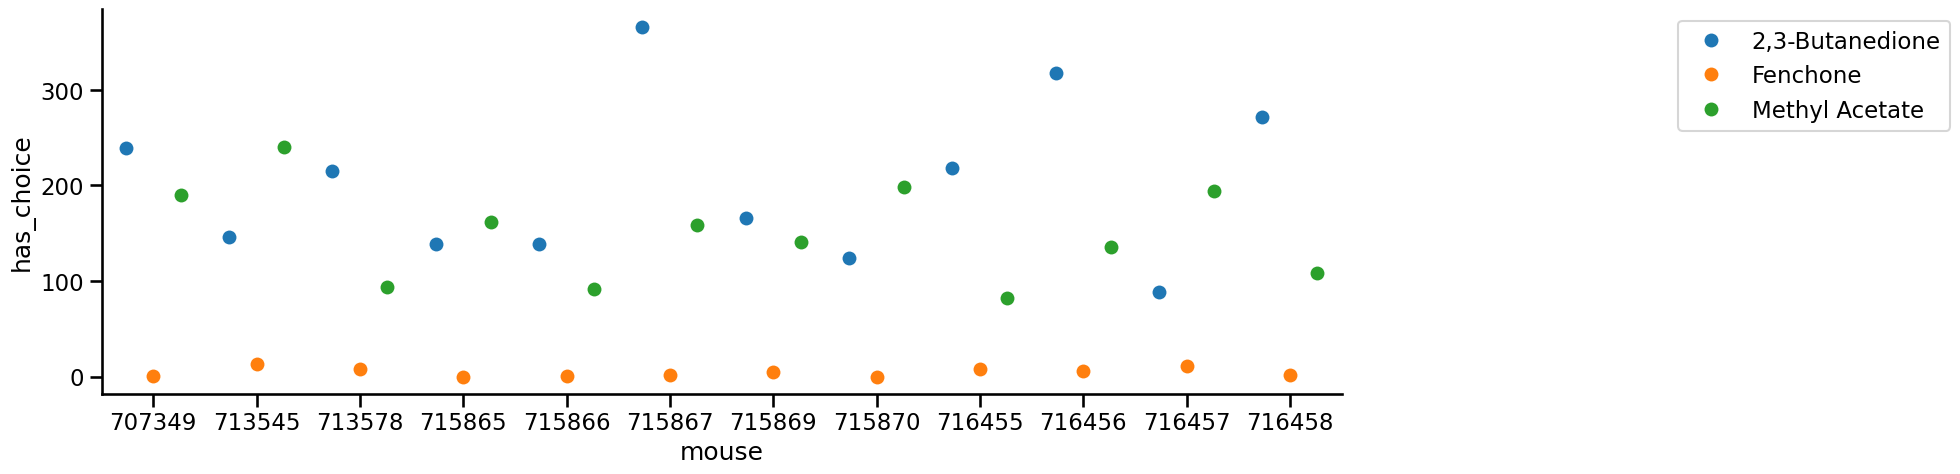

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(16, 5))
summary = summary_df.groupby(['mouse', 'odor_label']).has_choice.sum().reset_index()
sns.swarmplot(data=summary, x='mouse', y='has_choice', hue='odor_label', dodge=True, size=10)
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right')
sns.despine()

In [ ]:
def speed_traces_available(trial_summary, mouse, session, config, window = (-1, 3), save=False):
    n_odors = len(trial_summary.odor_label.unique())
    fig, ax = plt.subplots(n_odors,5, figsize=(18, len(trial_summary.odor_label.unique())*4), sharex=True, sharey=True)
    colors = ['crimson','darkgreen']
    for j in range(len(trial_summary.odor_label.unique())):
        if n_odors == 1:
            ax1 = ax
        else:
            ax1 = ax[j]
        ax1[0].set_ylabel('Velocity (cm/s)')

        for i in [0,1,2,3,4]:
            if n_odors == 1:
                ax[i].set_xlabel('Time after odor onset (s)')
            else:
                ax[len(trial_summary.odor_label.unique())-1][j].set_xlabel('Time after odor onset (s)')

            ax1[i].set_ylim(-10,80)
            ax1[i].set_xlim(window)
            ax1[i].hlines(5, window[0], window[1], color='black', linewidth=1, linestyles=':')
            ax1[i].fill_betweenx(np.arange(-10,80,0.1), window[0],0, color='#808080', alpha=.5, linewidth=0)

    for i in trial_summary.has_choice.unique():
        i = int(i)
        for j, odor_label in enumerate(trial_summary.odor_label.unique()):
            if n_odors == 1:
                ax1 = ax
            else:
                ax1 = ax[j]
            
            # Choose plot coloring different reward available in site   
            if trial_summary.reward_available.nunique() != 1:
                palette_dict = choose_palette(odor_label, trial_summary.loc[(trial_summary.odor_label == odor_label)], config)

                df_results = (trial_summary.loc[(trial_summary.odor_label == odor_label)&(trial_summary.has_choice == i)]
                            .groupby(['reward_available','odor_sites','times','amount'])[['speed']].mean().reset_index())
                
                if df_results.empty:
                    continue
                            
                sns.lineplot(x='times', y='speed', data=df_results, hue='reward_available',  palette=palette_dict, ci=None,legend=False, ax= ax1[i+2])   
                for site in df_results.odor_sites.unique():
                    plot_df = df_results.loc[df_results.odor_sites==site]
                    sns.lineplot(x='times', y='speed', data=plot_df, color=palette_dict[plot_df['reward_available'].unique()[0]], legend=False, linewidth=0.5, alpha=0.5, ax=ax1[i])  
                    
            else:
                colors_reward=sns.color_palette("RdYlBu", n_colors=trial_summary.reward_delivered.nunique())
                palette_dict = dict(zip(sorted(trial_summary.reward_delivered.unique()), colors_reward))
                
                df_results = (trial_summary.loc[(trial_summary.odor_label == odor_label)&(trial_summary.has_choice == i)]
                        .groupby(['reward_delivered','odor_sites','times'])[['speed']].mean().reset_index())
                
                if df_results.empty:
                    continue
                            
                sns.lineplot(x='times', y='speed', data=df_results, hue='reward_delivered',  palette=palette_dict, ci=None,legend=False, ax= ax1[i+2])   
                for site in df_results.odor_sites.unique():
                    plot_df = df_results.loc[df_results.odor_sites==site]
                    sns.lineplot(x='times', y='speed', data=plot_df, color=palette_dict[plot_df['reward_delivered'].unique()[0]], legend=False, linewidth=0.5, alpha=0.5, ax=ax1[i])  
                
            sns.lineplot(x='times', y='speed', data=df_results, color=colors[i], palette=palette_dict, ci=('sd'), ax= ax1[4])      

            ax1[2].set_title(f'Odor {odor_label} ')
            
            if i == 1:
                ax1[i].text(1.2, 75, f'Stopped', fontsize=12)
                ax1[i+2].text(1.2, 75, f'Stopped', fontsize=12)
            else:
                ax1[i].text(1.2, 75, f'Not stopped', fontsize=12)
                ax1[i+2].text(1.2, 75, f'Not stopped', fontsize=12)
            
    sns.despine()     
    
    plt.suptitle(mouse +'_' + session)       
    plt.tight_layout()

    if save != False:
        save.savefig(fig)
        plt.close(fig)


In [ ]:
speed_traces_available(trial_summary, mouse, session, data['config'])